<a href="https://colab.research.google.com/github/jannatpritha/phishing_detection/blob/main/Final_Code_Phishing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Import Section

In [ ]:
#install TLD
!pip install tld
from tld import get_tld, is_tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
import re
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np

In [ ]:
import seaborn as sns

In [ ]:
from urllib.parse import urlparse

In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/1176 Data/malicious_phish.csv')
dataset.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


# Preprocessing

In [ ]:
#Clean Dataset for Unwanted Values
dataset.dropna(subset=['url'], inplace=True)
dataset.dropna(subset=['type'], inplace=True)
def data_preprocess(dataset):
    assert isinstance(dataset, pd.DataFrame)
    dataset.dropna(inplace=True)
    left_ones = ~dataset.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return dataset[left_ones].astype(np.float64)

#remove WWW
dataset['url'] = dataset['url'].replace('www.', '', regex=True)

In [ ]:
#Assign Values to the Type Accordingly
detection_type= {"Group": {"benign":0,"malware":3,"phishing":1,"defacement":2}}
dataset['Group'] = dataset['type']
dataset = dataset.replace(detection_type)
dataset

,url,type,Group
0,br-icloud.com.br,phishing,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2
...,...,...,...
120797,mcalighting.com,phishing,1
120798,docstoc.com/docs/68025457/am2009,benign,0
120799,stmichael-stpeter.org/,benign,0
120800,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,1


# Feature Extraction

In [ ]:
#find if the url belongs to a specific IP Address

def does_have_ip_address(url):
    pattern = (
        r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})/)'
        r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        r'([01]?\d\d?|2[0-4]\d|25[0-5]):\d+)/|'  # IPv4 with port
        r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:/\d{1,2})?)'
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        r'([01]?\d\d?|2[0-4]\d|25[0-5])/)|'  # IPv4
    )
    find_ = re.search(pattern, url)
    if find_:
        return 1
    else:
        return 0

In [ ]:
#find the domain of the URL
def finding_domainName(given_url):
    try:
        value = get_tld(given_url, as_object = True, fail_silently=False,fix_protocol=True)
        name_of_dom= value.parsed_url.netloc
    except :
        name_of_dom= None
    return name_of_dom

In [ ]:
#Finds Unusual Urls
def find_unusual_url(given_url):
    urlname = urlparse(given_url).hostname
    urlname = str(urlname)
    find_match = re.search(urlname, given_url)
    if find_match:
        return 1
    else:
        return 0

In [ ]:
#It finds if the http is secure or not
def find_if_http_is_secure(given_url):
    is_secure = urlparse(given_url).scheme
    find_match = str(is_secure)
    if find_match=='https':
        return 1
    else:
        return 0

In [ ]:
#Count each digit of the url and return the total value
def count_each_digit(given_url):
    value = 0
    for b in given_url:
        if b.isnumeric():
            value = value + 1
    return value

In [ ]:
#find if the url used any shortening website
def is_the_url_shortened(given_url):
    find_ = re.search('goo\.gl|shorte\.st|bit\.ly|x\.co|go2l\.ink|tinyurl|ow\.ly|tr\.im|t\.co|is\.gd|cli\.gs|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'migre\.me|yfrog\.com|ff\.im|tiny\.cc|twit\.ac|url4\.eu|su\.pr|snipurl\.com|twurl\.nl|'
                      'db\.tt|adf\.ly|qr\.ae|goo\.gl|cur\.lv|bitly\.com|tinyurl\.com|bit\.ly|ow\.ly|ity\.im|'
                      'doiop\.com|kl\.am|short\.ie|wp\.me|om\.ly|to\.ly|rubyurl\.com|bit\.do|t\.co|lnkd\.in|'
                      'q\.gs|po\.st|is\.gd|bc\.vc|twitthis\.com|j\.mp|u\.to|buzurl\.com|u\.bb|cutt\.us|yourls\.org|'
                      'link\.zip\.net|tr\.im'
                      'prettylinkpro\.com|x\.co|scrnch\.me|vzturl\.com|filoops\.info|qr\.net|1url\.com|v\.gd|tweez\.me|'
                      ,
                      given_url)
    if find_:
        return 1
    else:
        return 0

In [ ]:
dataset['find_length_of_url'] = dataset['url'].apply(lambda k: len(str(k)))
dataset['is_ip'] = dataset['url'].apply(lambda k: does_have_ip_address(k))
dataset['domain_name']= dataset['url'].apply(lambda k:finding_domainName(k))
dataset['unusual_url'] = dataset['url'].apply(lambda k: find_unusual_url(k))
dataset['is_secure'] = dataset['url'].apply(lambda k: find_if_http_is_secure(k))
dataset['digits']= dataset['url'].apply(lambda k: count_each_digit(k))
dataset['is_short'] = dataset['url'].apply(lambda k: is_the_url_shortened(k))

In [ ]:
#for each signs creates a new column to count how many sign it has
alphaneumeric_character = ['@','?','-','=','.','#','%','+','$','!','*',',','//','~','^']
for character in alphaneumeric_character:
    dataset[character] = dataset['url'].apply(lambda i: i.count(character))

In [ ]:
dataset.head(5)

,url,type,Group,find_length_of_url,is_ip,domain_name,unusual_url,is_secure,digits,is_short,...,#,%,+,$,!,*,",",//,~,^
0,br-icloud.com.br,phishing,1,16,1,br-icloud.com.br,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,1,mp3raid.com,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,1,bopsecrets.org,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,2,84,1,garage-pirenne.be,1,0,7,1,...,0,0,0,0,0,0,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2,235,1,adventure-nicaragua.net,1,0,22,1,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
dataset

,url,type,Group,find_length_of_url,is_ip,domain_name,unusual_url,is_secure,digits,is_short,...,#,%,+,$,!,*,",",//,~,^
0,br-icloud.com.br,phishing,1,16,1,br-icloud.com.br,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,1,mp3raid.com,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,1,bopsecrets.org,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,2,84,1,garage-pirenne.be,1,0,7,1,...,0,0,0,0,0,0,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2,235,1,adventure-nicaragua.net,1,0,22,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120797,mcalighting.com,phishing,1,15,1,mcalighting.com,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
120798,docstoc.com/docs/68025457/am2009,benign,0,32,1,docstoc.com,0,0,12,1,...,0,0,0,0,0,0,0,0,0,0
120799,stmichael-stpeter.org/,benign,0,22,1,stmichael-stpeter.org,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
120800,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,1,202,1,appleid.apple.co.uk.cgi-bin.webobjects.myapple...,1,0,24,1,...,0,0,0,0,0,0,0,1,0,0


# ML Section

In [ ]:
#Divide Data Set
X = dataset.drop(['url','type','Group','domain_name'],axis=1)
y = dataset['Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

The model is  => <class 'sklearn.ensemble._forest.RandomForestClassifier'>  => 

Accuracy for : 93.61%  is

                             Classification Report                              
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     17773
           1       0.70      0.26      0.38      1434
           2       0.94      0.96      0.95      4409
           3       0.91      0.76      0.83       545

    accuracy                           0.94     24161
   macro avg       0.87      0.74      0.78     24161
weighted avg       0.93      0.94      0.93     24161

                                Confusion Matrix                                


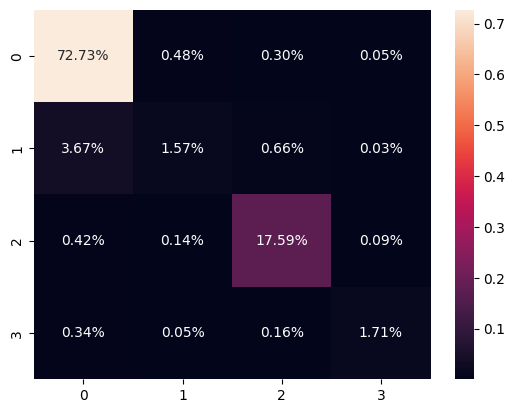

The model is  => <class 'sklearn.neighbors._classification.KNeighborsClassifier'>  => 

Accuracy for : 91.97%  is

                             Classification Report                              
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     17773
           1       0.58      0.27      0.37      1434
           2       0.91      0.93      0.92      4409
           3       0.86      0.63      0.73       545

    accuracy                           0.92     24161
   macro avg       0.82      0.70      0.74     24161
weighted avg       0.91      0.92      0.91     24161

                                Confusion Matrix                                


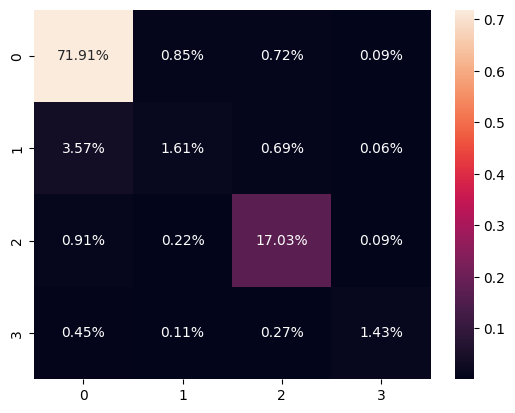

The model is  => <class 'sklearn.naive_bayes.GaussianNB'>  => 

Accuracy for : 50.44%  is

                             Classification Report                              
              precision    recall  f1-score   support

           0       0.99      0.37      0.54     17773
           1       0.09      0.68      0.16      1434
           2       0.70      1.00      0.82      4409
           3       0.23      0.33      0.27       545

    accuracy                           0.50     24161
   macro avg       0.50      0.59      0.45     24161
weighted avg       0.87      0.50      0.57     24161

                                Confusion Matrix                                


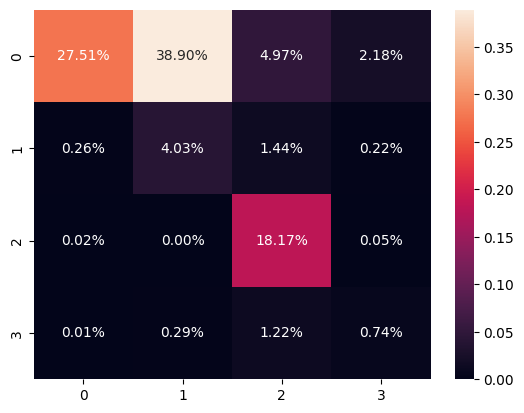

The model is  => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>  => 

Accuracy for : 34.70%  is

                             Classification Report                              
              precision    recall  f1-score   support

           0       0.89      0.17      0.28     17773
           1       0.09      0.78      0.16      1434
           2       0.87      0.93      0.90      4409
           3       0.05      0.28      0.08       545

    accuracy                           0.35     24161
   macro avg       0.47      0.54      0.36     24161
weighted avg       0.82      0.35      0.38     24161

                                Confusion Matrix                                


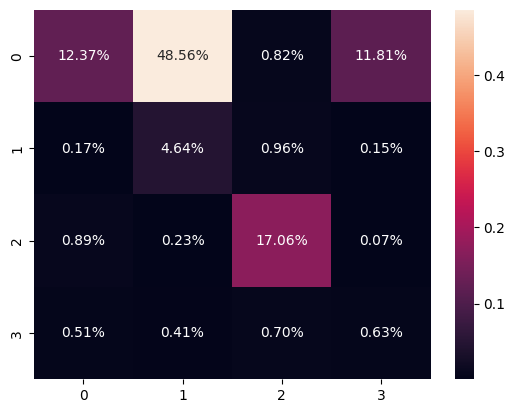

The model is  => <class 'xgboost.sklearn.XGBClassifier'>  => 

Accuracy for : 93.43%  is

                             Classification Report                              
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     17773
           1       0.78      0.24      0.36      1434
           2       0.93      0.97      0.95      4409
           3       0.92      0.64      0.76       545

    accuracy                           0.93     24161
   macro avg       0.89      0.71      0.76     24161
weighted avg       0.93      0.93      0.92     24161

                                Confusion Matrix                                


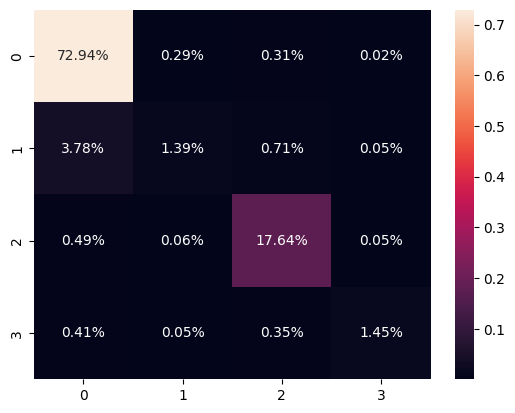

In [ ]:
ml_algorithm = [RandomForestClassifier,KNeighborsClassifier,GaussianNB,AdaBoostClassifier,XGBClassifier]

for ml in ml_algorithm:

    print('The model is  =>\033[07m {} \033[0m => '.format(ml))

    algo = ml()

    algo.fit(X_train, y_train)
    calculation = algo.predict(X_test)
    accuracy_result = accuracy_score(calculation, y_test)
    print()
    print('Accuracy for : {:.2f}%  is'.format(accuracy_result*100))
    print()
    #print('Here it is the Classification Report')
    print(chr(0x1D) + 'Classification Report'.center(80) + chr(0x1D))
    print(classification_report(y_test, calculation))
    print(chr(0x1D) + 'Confusion Matrix'.center(80) + chr(0x1D))

    confusion_mat = confusion_matrix(y_test, calculation)
    plot_ = sns.heatmap(confusion_mat/np.sum(confusion_mat), annot=True,fmt= '0.2%')
    plt.show()

# Real Time URL Checking

In [ ]:
# Take input from the user
url = input("Provide a URL ")

Provide a URL http://www.volstrokebisa.shop/


In [ ]:
# create a dictionary of data
test_data = {'urls': [url]}

# loop through the list and replace 'www.' with an empty string
for b in range(len(test_data['urls'])):
    test_data['urls'][b] = test_data['urls'][b].replace('www.', '')

# convert the dictionary to a dataframe
df = pd.DataFrame(test_data)

In [ ]:
#Finds Unusual Urls
def find_unusual_url(given_url):
    urlname = urlparse(given_url).hostname
    urlname = str(urlname)
    find_match = re.search(urlname, given_url)
    if find_match:
        return 1
    else:
        return 0

#It finds if the http is secure or not
def find_if_http_is_secure(given_url):
    is_secure = urlparse(given_url).scheme
    find_match = str(is_secure)
    if find_match=='https':
        return 1
    else:
        return 0

#Count each digit of the url and return the total value
def count_each_digit(given_url):
    value = 0
    for b in given_url:
        if b.isnumeric():
            value = value + 1
    return value

#find if the url used any shortening website
def is_the_url_shortened(given_url):
    find_match = re.search('goo\.gl|shorte\.st|bit\.ly|x\.co|go2l\.ink|tinyurl|ow\.ly|tr\.im|t\.co|is\.gd|cli\.gs|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'migre\.me|yfrog\.com|ff\.im|tiny\.cc|twit\.ac|url4\.eu|su\.pr|snipurl\.com|twurl\.nl|'
                      'db\.tt|adf\.ly|qr\.ae|goo\.gl|cur\.lv|bitly\.com|tinyurl\.com|bit\.ly|ow\.ly|ity\.im|'
                      'doiop\.com|kl\.am|short\.ie|wp\.me|om\.ly|to\.ly|rubyurl\.com|bit\.do|t\.co|lnkd\.in|'
                      'q\.gs|po\.st|is\.gd|bc\.vc|twitthis\.com|j\.mp|u\.to|buzurl\.com|u\.bb|cutt\.us|yourls\.org|'
                      'link\.zip\.net|tr\.im'
                      'prettylinkpro\.com|x\.co|scrnch\.me|vzturl\.com|filoops\.info|qr\.net|1url\.com|v\.gd|tweez\.me|'
                      ,
                      given_url)
    if find_match:
        return 1
    else:
        return 0

#find if the url belongs to a specific IP Address

def does_have_ip_address(url):
    pattern = (
       r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})/)'
       r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
       r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
       r'([01]?\d\d?|2[0-4]\d|25[0-5]):\d+)/|'  # IPv4 with port
       r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:/\d{1,2})?)'
       r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
       r'([01]?\d\d?|2[0-4]\d|25[0-5])/)|'  # IPv4
    )
    find_match = re.search(pattern, url)
    if find_match:
        return 1
    else:
        return 0

# apply the len() function to the 'urls' column
df['find_length_of_url']= df['urls'].apply(lambda x: len(str(x)))
df['is_ip'] = df['urls'].apply(lambda x: does_have_ip_address(x))
df['unusual_url'] = df['urls'].apply(lambda x: find_unusual_url(x))
df['is_secure'] = df['urls'].apply(lambda x: find_if_http_is_secure(x))
df['digits']= df['urls'].apply(lambda x: count_each_digit(x))
df['is_short'] = df['urls'].apply(lambda x: is_the_url_shortened(x))



#for each signs creates a new column to count how many sign it has
sign = ['@','?','-','=','.','#','%','+','$','!','*',',','//','~','^']
for b in sign:
    df[b] = df['urls'].apply(lambda x: x.count(b))

In [ ]:
test_url = df.drop(['urls'],axis=1)#,'type_code'
test_url

,find_length_of_url,is_ip,unusual_url,is_secure,digits,is_short,@,?,-,=,...,#,%,+,$,!,*,",",//,~,^
0,26,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
algo = [RandomForestClassifier,KNeighborsClassifier,GaussianNB,AdaBoostClassifier,XGBClassifier]

for a in algo:

    print('The model is  =>\033[07m {} \033[0m'.format(a))
    #initializes the model
    model_all = a()
    model_all.fit(X_train, y_train)
    prediction = model_all.predict(test_url)
    if prediction == 0:
      print("It is Benign")
    elif prediction == 1:
      print("It is Phishing")
    elif prediction == 2:
      print("It is Defacement")
    elif prediction == 3:
      print("It is Malware")

The model is  => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
It is Defacement
The model is  => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
It is Defacement
The model is  => <class 'sklearn.naive_bayes.GaussianNB'> 
It is Defacement
The model is  => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
It is Defacement
The model is  => <class 'xgboost.sklearn.XGBClassifier'> 
It is Defacement


In [ ]:
models = [XGBClassifier]
pred = 1
for a in models:

    print('The result from XGBoost is')
    #initializes the model
    model_xgb = a()
    model_xgb.fit(X_train, y_train)
    prediction = model_xgb.predict(test_url)
    if prediction == 0:
      print("It is Benign")
    elif prediction == 1:
      print("It is Phishing")
    elif prediction == 2:
      print("It is Defacement")
    elif prediction == 3:
      print("It is Malware")

The result from XGBoost is
It is Defacement


In [ ]:
models = [RandomForestClassifier]
pred = 1
for a in models:

    print('The result from Random Forest is')
    #initializes the model
    model_xgb = a()
    model_xgb.fit(X_train, y_train)
    prediction = model_xgb.predict(test_url)
    if prediction == 0:
      print("It is Benign")
    elif prediction == 1:
      print("It is Phishing")
    elif prediction == 2:
      print("It is Defacement")
    elif prediction == 3:
      print("It is Malware")

The result from Random Forest is
It is Defacement
